In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [40]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() 

In [41]:
# Load the Dataset 
df = pd.read_csv('./data_with_indicators/crypto_prices_1m_with_indicators.csv', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Number of Trades,Coin,EMA9,EMA21,...,STOCHS_Sell,+DI,-DI,ADX,ADX_Buy,ADX_Sell,Aroon_Up,Aroon_Down,Aroon_Buy,Aroon_Sell
0,2024-12-31 16:00:00,95412.00,95454.55,95308.00,95308.01,15.17924,4110,BTC,95308.010000,95308.010000,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
1,2024-12-31 16:01:00,95308.01,95386.03,95291.66,95361.49,17.54599,3991,BTC,95318.706000,95312.871818,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
2,2024-12-31 16:02:00,95361.48,95373.81,95320.27,95352.26,10.70271,2292,BTC,95325.416800,95316.452562,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
3,2024-12-31 16:03:00,95352.26,95364.48,95250.00,95258.62,11.82793,4267,BTC,95312.057440,95311.195056,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
4,2024-12-31 16:04:00,95258.61,95304.37,95201.78,95272.29,19.69380,5153,BTC,95304.103952,95307.658233,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False


In [42]:
# Faceted EDA with enhanced styling
crypto = ['BTC', 'ETH', 'SOL', 'XRP']
colors = ['tab:purple', 'tab:green', 'tab:red', 'tab:blue']

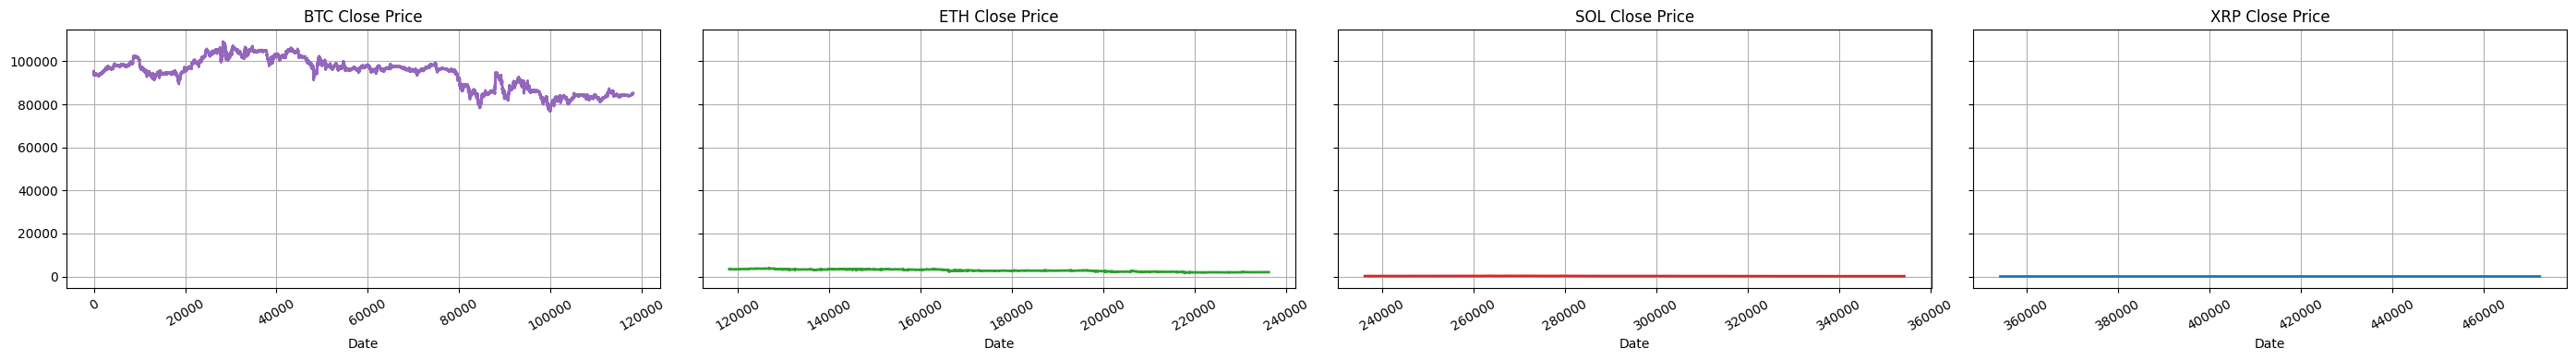

In [43]:
# Close Price Trends Facet 
fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4), sharey=True)
for ax, ticker, color in zip(axes, crypto, colors):
    df_ticker = df[df['Coin'] == ticker]
    ax.plot(df_ticker.index, df_ticker['Close'], color=color, linewidth=2)
    ax.set_title(f'{ticker} Close Price')
    ax.set_xlabel('Date')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
    ax.grid(True)
plt.tight_layout()
plt.show()

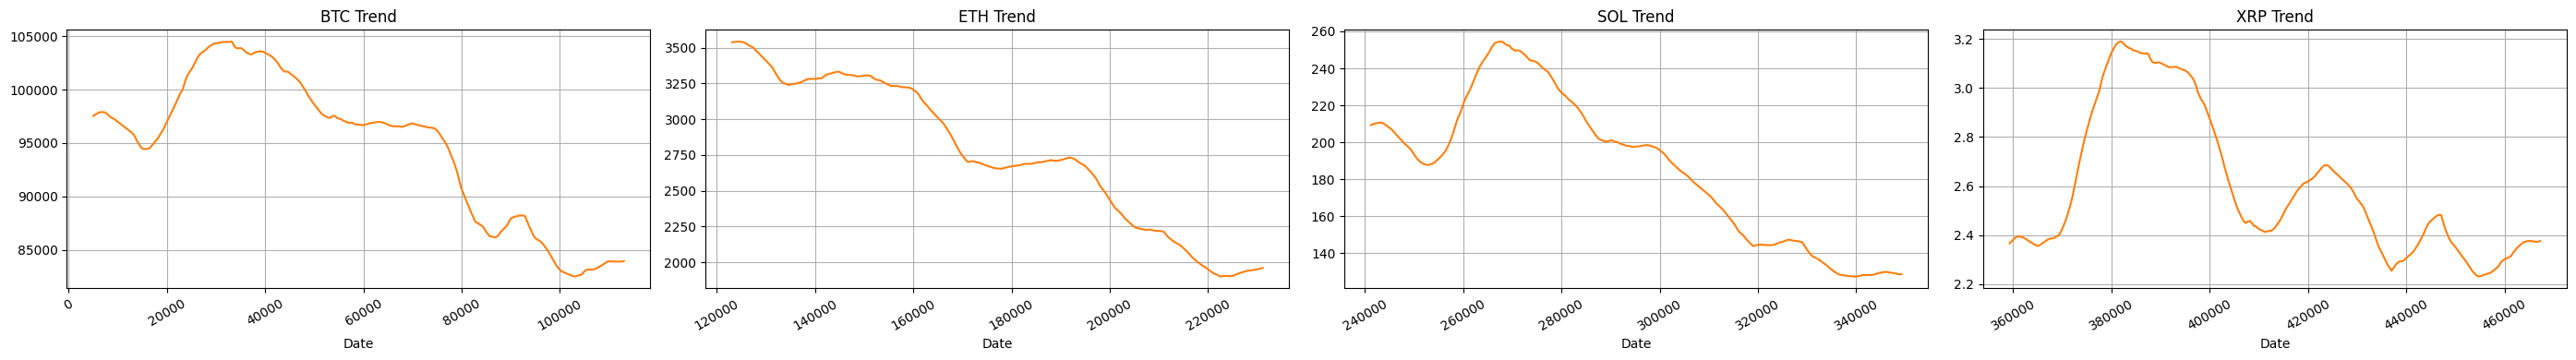

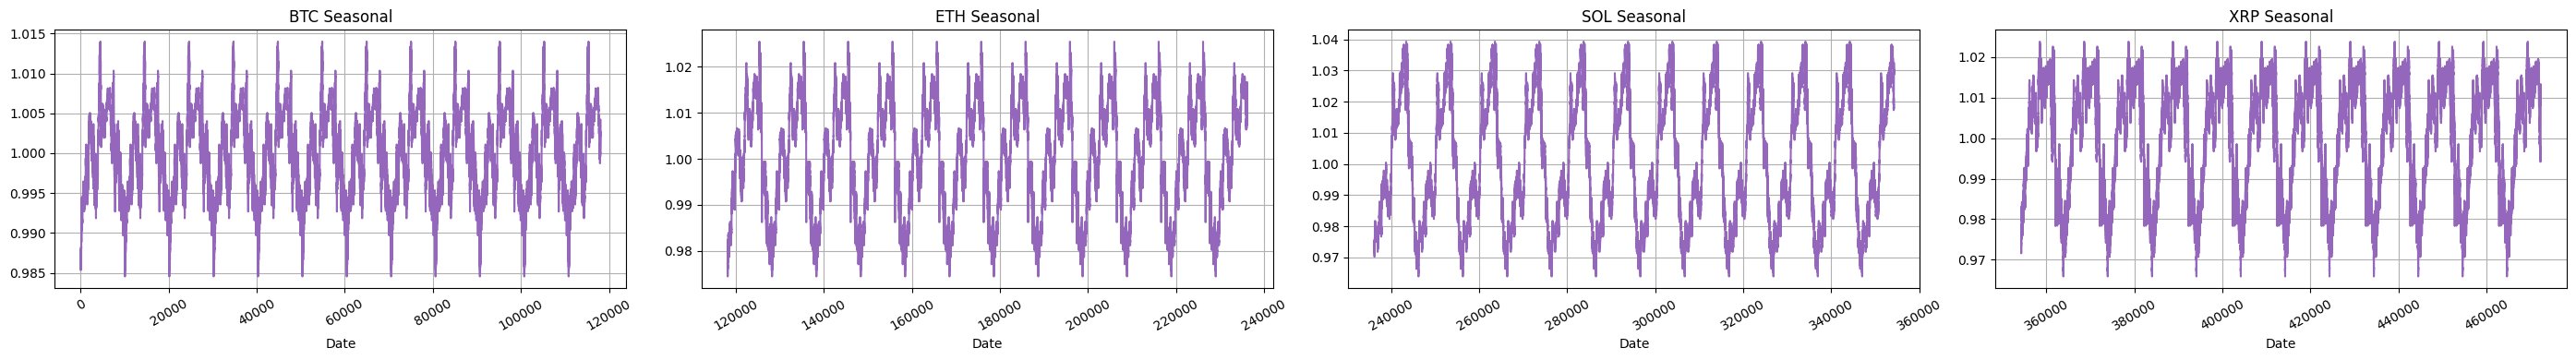

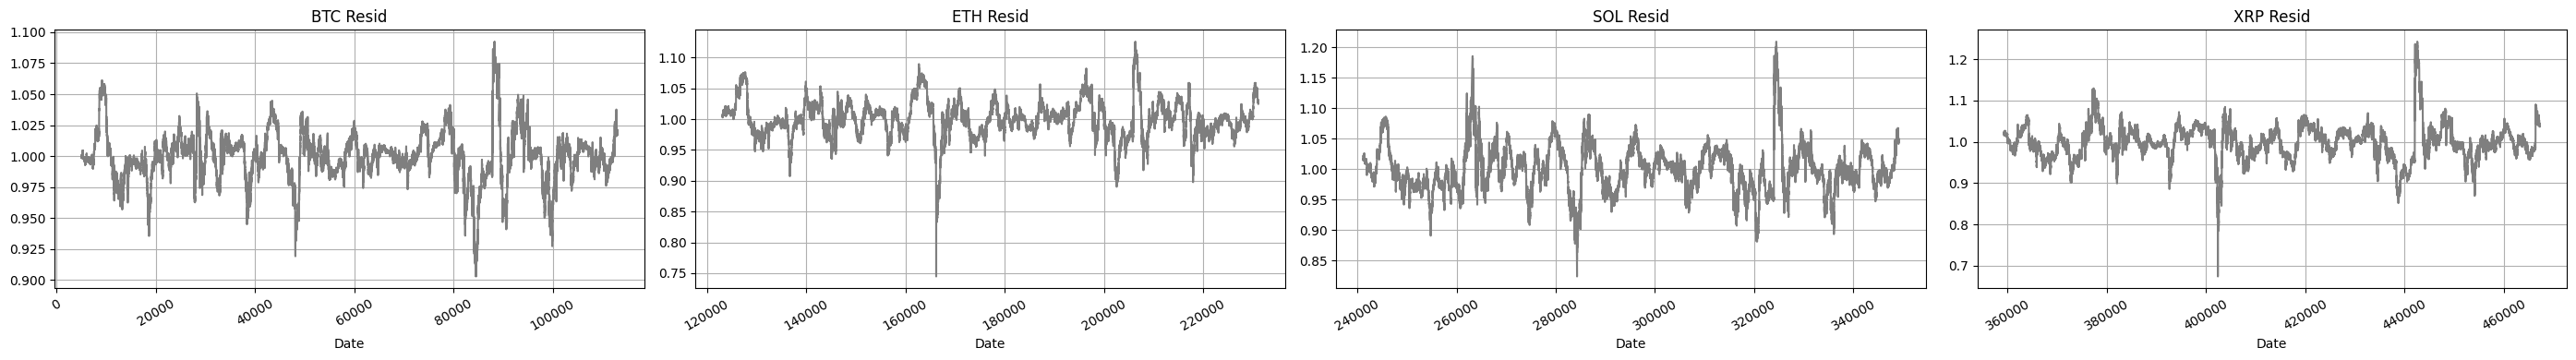

In [44]:
# Seasonal Decomposition Facet 
component_colors = {'trend': 'tab:orange', 'seasonal': 'tab:purple', 'resid': 'tab:gray'}
for comp, comp_color in component_colors.items():
    fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4))
    for ax, ticker, color in zip(axes, crypto, colors):
        df_ticker = df[df['Coin'] == ticker]
        # crypto prices fluctuate proportionally with price levels, therefore multiplicative model is used
        result = seasonal_decompose(df_ticker['Close'], model='multiplicative', period=10080) # 10080 minutes in a week
        comp_series = getattr(result, comp)
        ax.plot(comp_series.index, comp_series, color=comp_color)
        ax.set_title(f'{ticker} {comp.capitalize()}')
        ax.set_xlabel('Date')
        for label in ax.get_xticklabels():
            label.set_rotation(30)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# Analysis 
# Trend: Overall downward movements 
# Seasonal: Repeating patterns are visible - weekly seasonality
# Residual: Relatively stable noise, but some large spikes are visible (might be market shocks)

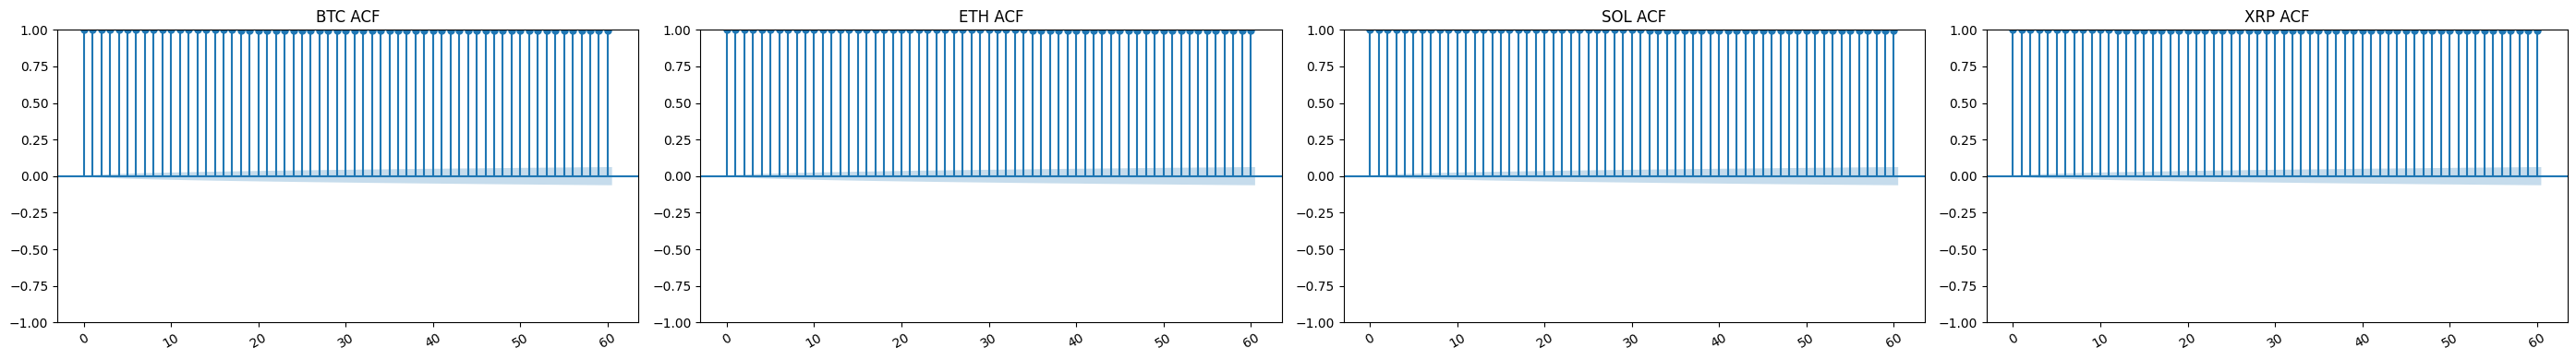

In [45]:
# Standard ACF Facet
fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4))
for ax, ticker in zip(axes, crypto):
    df_ticker = df[df['Coin'] == ticker]
    plot_acf(df_ticker['Close'].dropna(), lags=60, ax=ax)
    ax.set_title(f'{ticker} ACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

# High Autocorrelation: Plots show very high and persistent autocorrelations. All the bars are at the maximum value of 1, indicating a strong positive correlation at every lag.
# No Decay: There is no visible decay in the autocorrelation as the lag increases. This suggests that past values of prices are highly predictive of future values for a very long period.
# Stationarity: This pattern is indicative of a non-stationary time series. A stationary time series would typically show the autocorrelation decreasing as the lag increases, eventually falling within the confidence interval.
# When modeling prices, it's important to account for the non-stationarity.

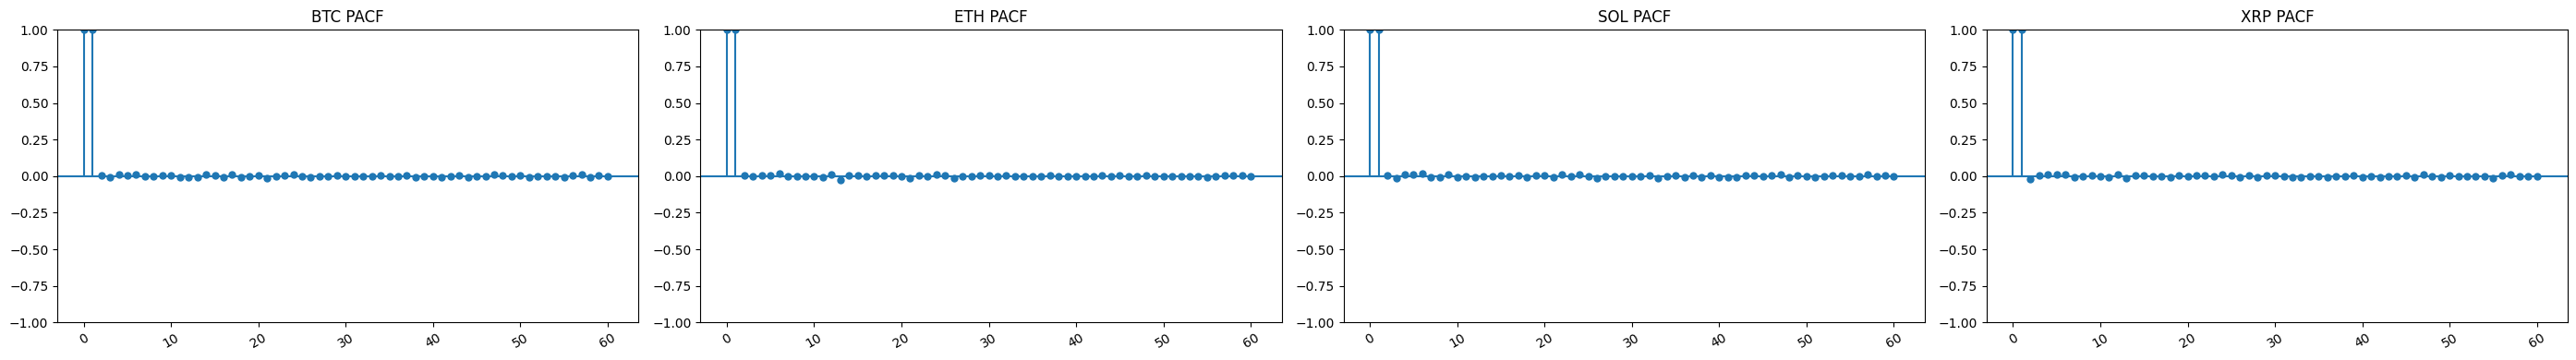

In [46]:
# Standard PACF Facet 
fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4))
for ax, ticker in zip(axes, crypto):
    df_ticker = df[df['Coin'] == ticker]
    plot_pacf(df_ticker['Close'].dropna(), lags=60, ax=ax)
    ax.set_title(f'{ticker} PACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

In [47]:
# Stationarity Tests
for ticker in crypto:
    df_ticker = df[df['Coin'] == ticker]
    adf_result = adfuller(df_ticker['Close'].dropna())
    print(f'ADF Statistic for {ticker}: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
    if adf_result[1] < 0.05:
        print(f"{ticker} series is likely stationary.")
    else:
        print(f"{ticker} series is likely non-stationary.")

ADF Statistic for BTC: -1.4279, p-value: 0.5688
BTC series is likely non-stationary.
ADF Statistic for ETH: -0.8515, p-value: 0.8035
ETH series is likely non-stationary.
ADF Statistic for SOL: -0.8681, p-value: 0.7983
SOL series is likely non-stationary.
ADF Statistic for XRP: -2.4175, p-value: 0.1369
XRP series is likely non-stationary.


In [ ]:
# Visualization of continuous technical indicators for each ticker
technical_columns = [col for col in df.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Number of Trades', 'Coin']]
for token, color in zip(crypto, colors):
    df_token = df[df['Coin'] == token]
    n_cols = 5
    n_rows = (len(technical_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(technical_columns):
        axes[i].plot(df_token.index, df_token[col], color=color)
        axes[i].set_title(col.replace('_', ' '), fontsize=10)
        axes[i].tick_params(axis='x', rotation=30)
        axes[i].grid(True)

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Continuous Technical Indicators Over Time for {token}', fontsize=16)
    plt.tight_layout()
    plt.show()